In [1]:
%reload_kedro

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2021-06-03 20:09:36,513 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-06-03 20:09:36,552 - root - INFO - ** Kedro project Foehn fire impact
2021-06-03 20:09:36,553 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-06-03 20:09:36,560 - root - INFO - Registered line magic `run_viz`


/home/chmony/Apps/anaconda3/envs/foehnfirecorrplot/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sci
from utils import *
import kedro.framework.context

plt.rcParams["figure.figsize"] = (16,9)
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

In [4]:
df = context.catalog.load("fire_data_with_foehn_and_control_variables")

2021-06-03 20:09:37,728 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


In [5]:
foehn_prevalence_fire_start = (df["foehn_minutes_during_12_hours_after_start_of_fire"] >0).sum()/df["foehn_minutes_during_12_hours_after_start_of_fire"].count()
foehn_prevalence_before_fire_start = (df["foehn_minutes_24_hour_before"] >0).sum()/df["foehn_minutes_24_hour_before"].count()

print(f"Foehn prevalent 12h after start of fire (%): {foehn_prevalence_fire_start}")
print(f"Foehn prevalent 24h before start of fire (%): {foehn_prevalence_before_fire_start}")

Foehn prevalent 12h after start of fire (%): 0.2930604093859211
Foehn prevalent 24h before start of fire (%): 0.40058337384540593


Fires longer than 6h (%): 0.2623445156426687
Fires longer than 12h (%): 0.1711270260082925


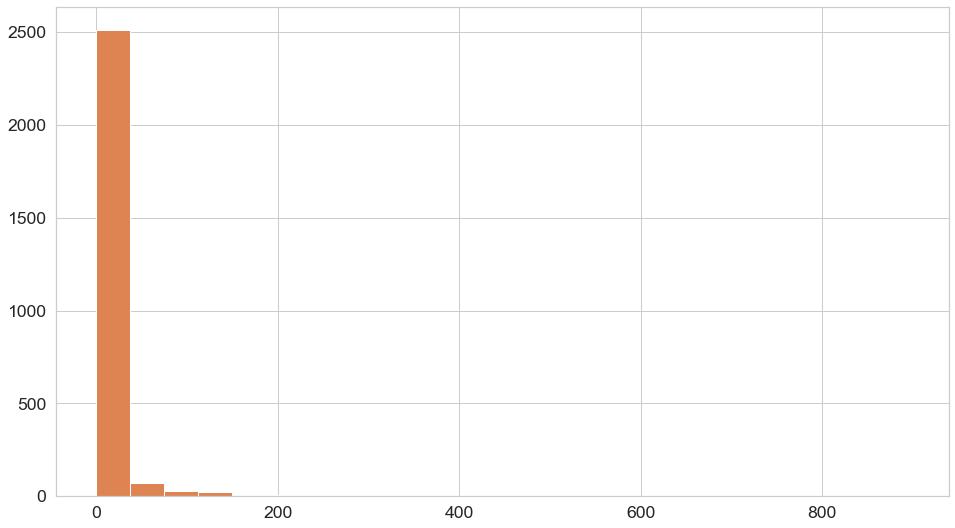

In [6]:
(df["duration_min"]).hist(bins=24)
(df["duration_max"]).hist(bins=24)

print(f"Fires longer than 6h (%): {(df['duration_min']> 6).sum()/df['duration_min'].count()}")
print(f"Fires longer than 12h (%): {(df['duration_min'] > 12).sum()/df['duration_min'].count()}")
#print(f"Foehn prevalent 24h before start of fire (%): {foehn_prevalence_before_fire_start}")

In [7]:
df.loc[:, "fire_regime"].value_counts(dropna=False, normalize=False)

Winter anthropogenic    1713
Summer anthropogenic     611
NaN                      329
Name: fire_regime, dtype: int64

# After fire ignition

In [ ]:
# Plot all (or selected) plots for 6 and 12 hours after fire start
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [6,12]:
        plot_multiple_binned_burned_area_after_fire_start(df, hours=hours, control_var=var)  

In [ ]:
test_multiple_bins_against_no_foehn(df, hours=12)

In [ ]:
# All fires
for hours in [6,12]:
    test_binary_bins(df, hours=hours)

In [ ]:
control_var_categories = {"": "",
                          "fire_regime": ["Winter anthropogenic", "Summer anthropogenic", "Summer natural"], 
                          "decade": ["[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]"],
                          "potential_foehn_species": ["North foehn", "South foehn"]}

In [ ]:
# For different fire regimes regimes
var = "fire_regime"
for hours in [6,12]:
    test_binary_bins(df, hours=hours, control_var=var, categories = control_var_categories[var])
    plot_binary_binned_burned_area_after_fire_start(df, hours=hours,control_var=var)

In [ ]:
# For different foehn types
var = "potential_foehn_species"
for hours in [6,12]:
    test_binary_bins(df, hours=hours, control_var=var, categories = control_var_categories[var])
    plot_binary_binned_burned_area_after_fire_start(df, hours=hours,control_var=var)

In [ ]:
# Test for significant difference between North and South Foehn
var = "potential_foehn_species"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = control_var_categories[var])

In [ ]:
# For different decades
var = "decade"
for hours in [6,12]:
    test_binary_bins(df, hours=hours, control_var=var, categories = control_var_categories[var])
    plot_binary_binned_burned_area_after_fire_start(df, hours=hours,control_var=var)

In [ ]:
# Test for significant difference in foehn between decades
var = "decade"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = control_var_categories[var][1:4])

north    2164
south     489
Name: region, dtype: int64
region
north    481
south     62
Name: With foehn influence (6h after start), dtype: int64


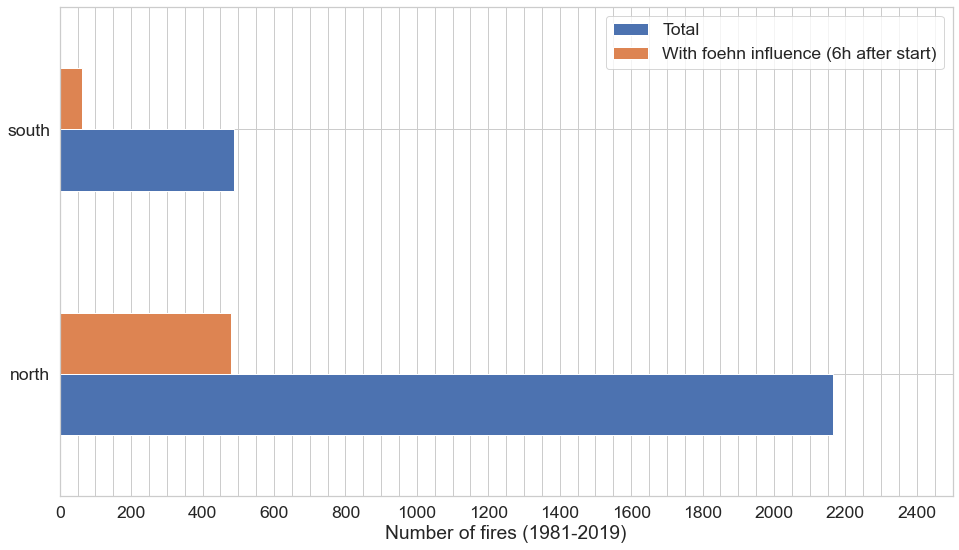

In [18]:
# Predefined regions and stations therein
# Eliminated stations: 
regions = context.config_loader.get("regions.json")

for region in regions.keys():
    for station in regions[region]:
        df.loc[(df["closest_station"] == station), "region"] = region
    
df_total = df.groupby("region").count()["total [ha]"].rename("Total")
df_onlyfoehn = df.loc[df["foehn_minutes_during_6_hours_after_start_of_fire"]>0, :].groupby("region").count()["total [ha]"].rename("With foehn influence (6h after start)")
pd.concat([df_total, df_onlyfoehn], axis=1).plot(kind="barh")
plt.xlabel("Number of fires (1981-2019)")
plt.ylabel("")
plt.xticks(range(0,2550, 50), labels=[str(i) if i%200 == 0 else "" for i in range(0,2550, 50)])
print(df["region"].value_counts(dropna=False, normalize=False))

print(df_onlyfoehn.sort_values(ascending=False))

## Wind strength influence

In [ ]:
bins_dict = {6: [2.5,14.9,27.6,52], 12: [1,10.7,21,52]}
#bins_dict = {6: [5,10,15,20], 12: [5,10,15,20]}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength(df.loc[df["region"] == region, :], hours=hour, strength_var="FF", bins=bins_dict[hour])
    break  

<AxesSubplot:>

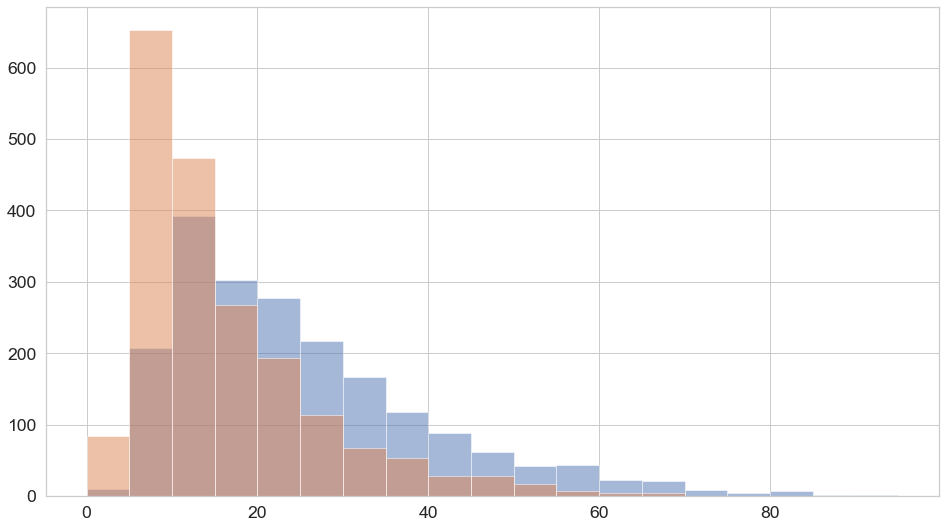

In [42]:
(df[f"FFX_q90_during_12_hours_after_start_of_fire"]).hist(bins=range(0,100,5), alpha=0.5)
(df[f"FFX_mean_during_12_hours_after_start_of_fire"]).hist(bins=range(0,100,5), alpha=0.5)

north
Amount of foehn-influenced fires:  481
(6h) (7.5, 27.0] (143) vs. (27.0, 52.1] (256) 	 0.039667 	 4.0
(6h) (7.5, 27.0] (143) vs. (52.1, 95.0] (81) 	 0.002499 	 10.0
(6h) (27.0, 52.1] (256) vs. (52.1, 95.0] (81) 	 0.131714 	 2.5
Amount of foehn-influenced fires:  518
(12h) (3, 21] (100) vs. (21, 35] (220) 	 0.592576 	 1.538
(12h) (3, 21] (100) vs. (35, 95] (198) 	 0.002313 	 4.923
(12h) (21, 35] (220) vs. (35, 95] (198) 	 0.003909 	 3.2


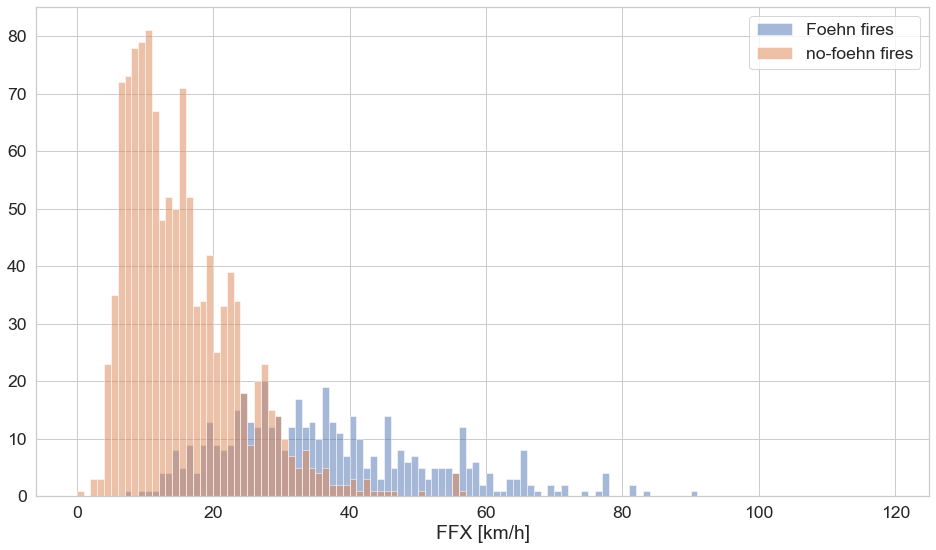

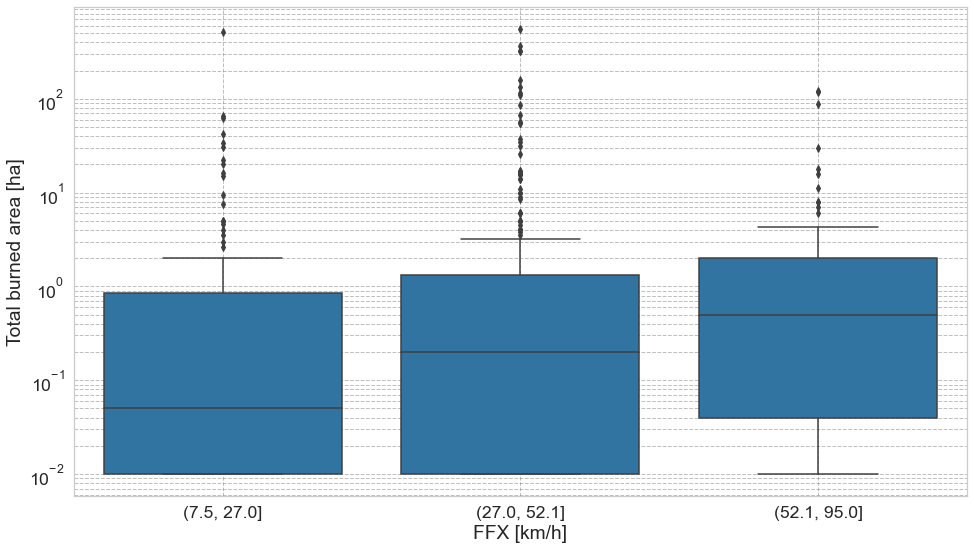

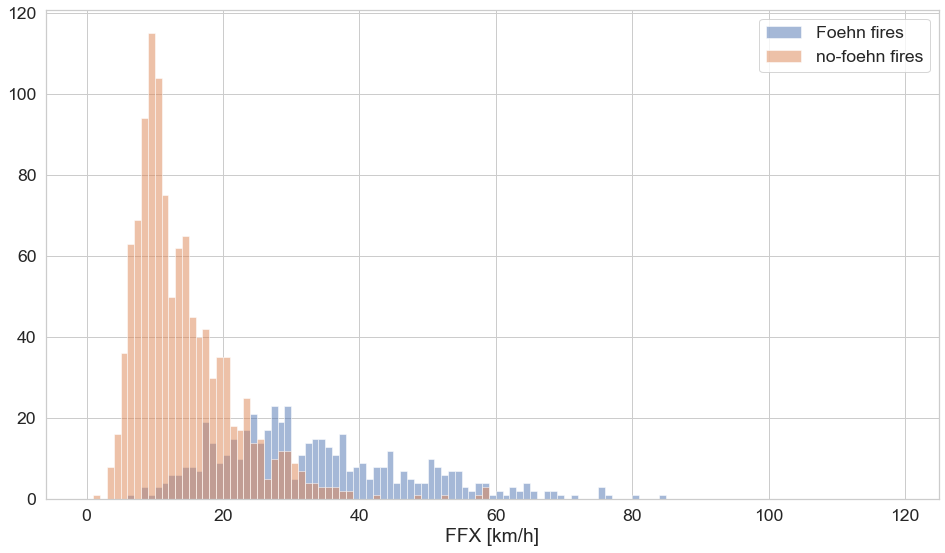

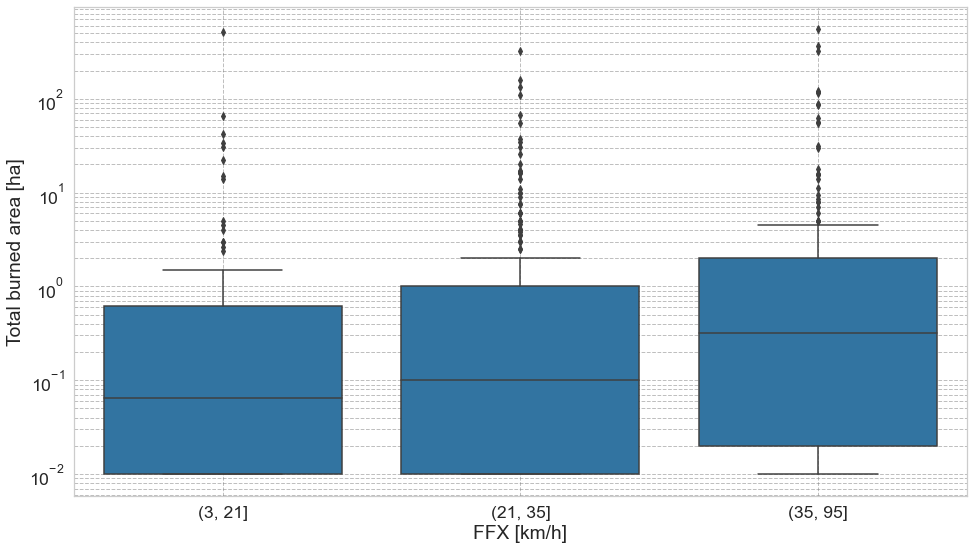

In [43]:
bins_dict = {6: [7.5,27,52.1,95], 12: [3,21,35,95]}
#bins_dict = {6: [15,20, 25, 30], 12: [10,15,20, 25]}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength(df.loc[df["region"] == region, :], hours=hour, strength_var="FFX", bins=bins_dict[hour])
    break

### Compare to non-foehn

north
Amount of foehn-influenced fires:  481
Amount of non-foehn-influenced fires:  1197
(6h) (0.0, 5.0] (foehnfires: 19), (nofoehnfires: 506) 	 0.60206
(6h) (5.0, 10.0] (foehnfires: 115), (nofoehnfires: 503) 	 0.279902
(6h) (10.0, 15.0] (foehnfires: 145), (nofoehnfires: 138) 	 0.507101
(6h) (15.0, 20.0] (foehnfires: 93), (nofoehnfires: 33) 	 0.534302
(6h) (20.0, 25.0] (foehnfires: 57), (nofoehnfires: 13) 	 0.134873
(6h) (25.0, 30.0] (foehnfires: 35), (nofoehnfires: 1) 	 0.193759
(6h) (30.0, 35.0] (foehnfires: 11), (nofoehnfires: 0) 	 nan
Amount of foehn-influenced fires:  518
Amount of non-foehn-influenced fires:  1160


/home/chmony/Apps/anaconda3/envs/foehnfirecorrplot/lib/python3.8/site-packages/scipy/stats/stats.py:7103: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(12h) (0.0, 5.0] (foehnfires: 17), (nofoehnfires: 580) 	 0.123905
(12h) (5.0, 10.0] (foehnfires: 183), (nofoehnfires: 484) 	 0.56127
(12h) (10.0, 15.0] (foehnfires: 160), (nofoehnfires: 79) 	 0.613433
(12h) (15.0, 20.0] (foehnfires: 80), (nofoehnfires: 9) 	 0.004549
(12h) (20.0, 25.0] (foehnfires: 52), (nofoehnfires: 5) 	 0.955009
(12h) (25.0, 30.0] (foehnfires: 20), (nofoehnfires: 0) 	 nan


/home/chmony/Apps/anaconda3/envs/foehnfirecorrplot/lib/python3.8/site-packages/scipy/stats/stats.py:7103: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


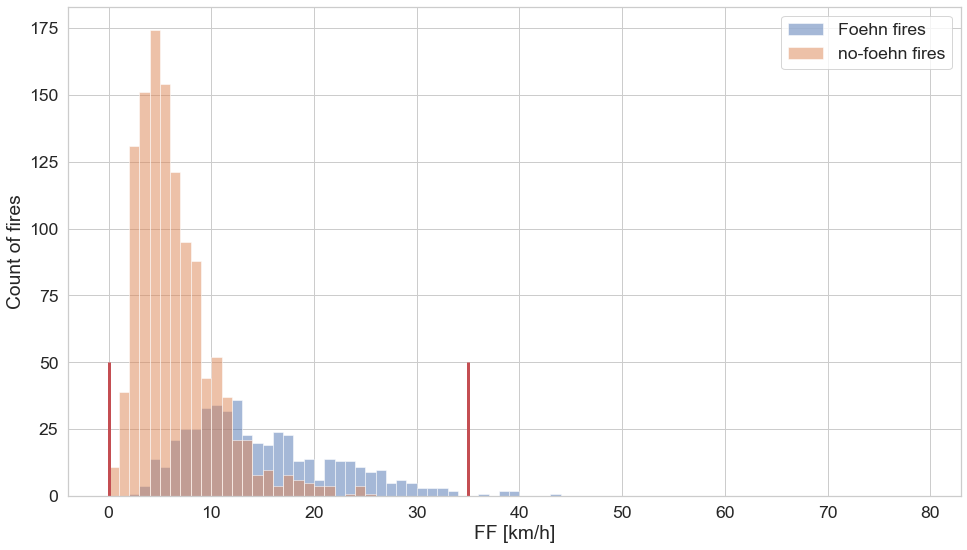

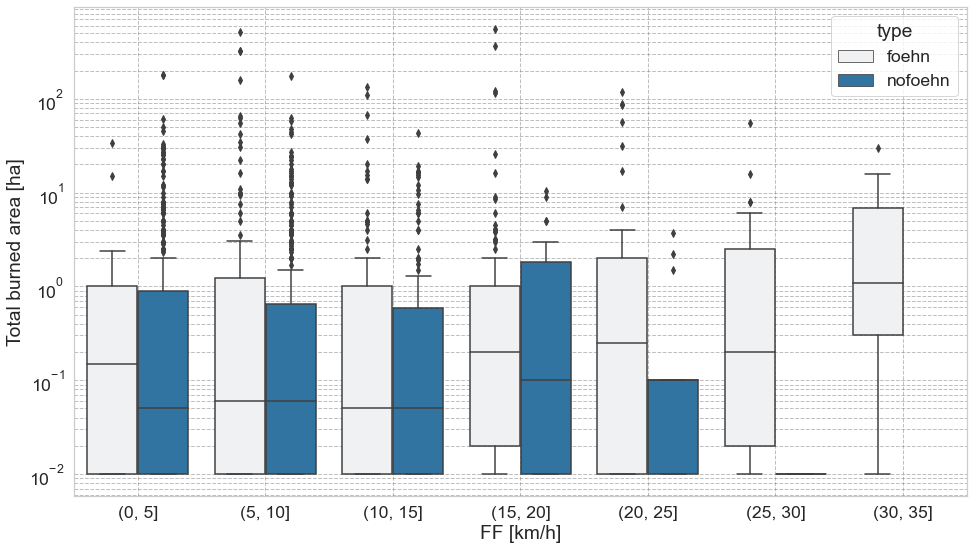

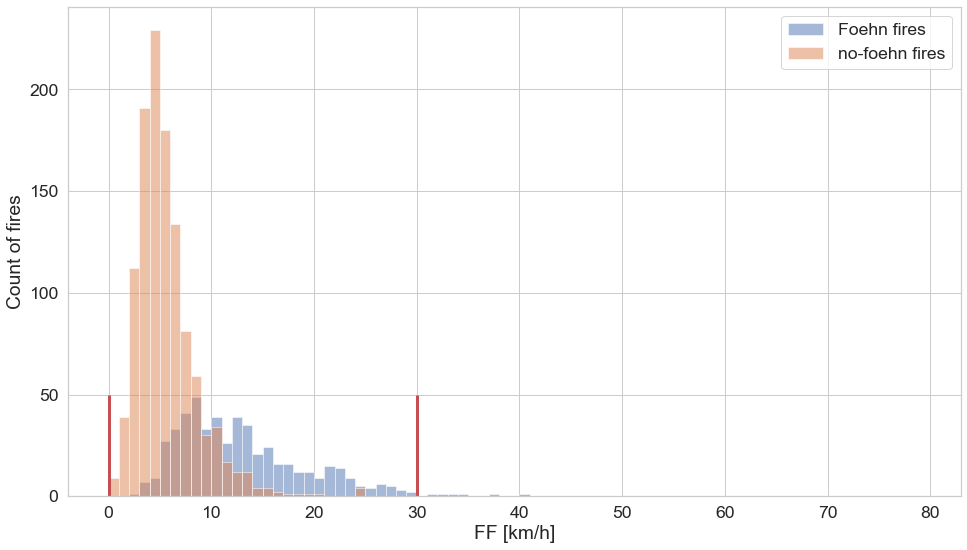

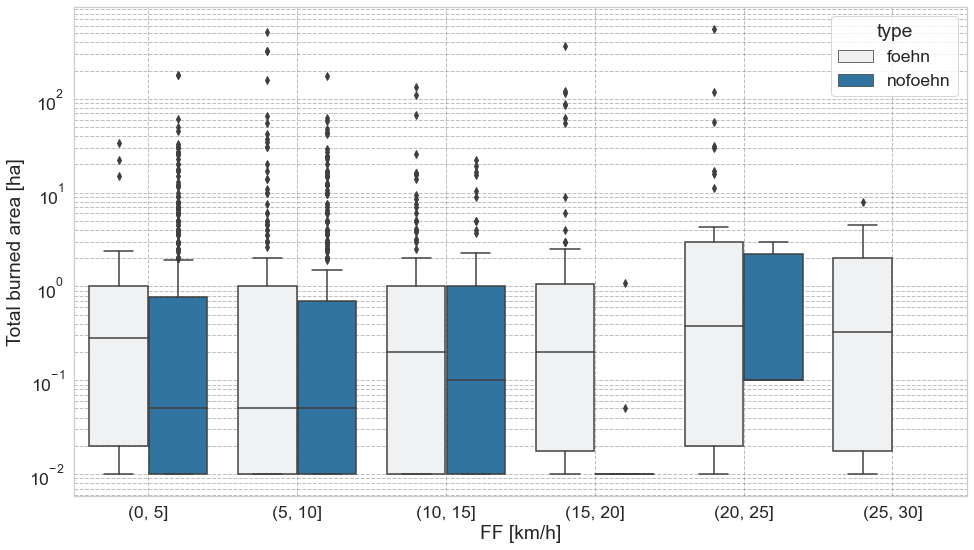

In [44]:
# OLD: bins_dict = {6: [5,6,11,60], 12: [0,6,10,60]}
bins_dict = {6: range(0,35+1,5), 12: range(0,30+1,5)}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength_foehn_nofoehn(df.loc[df["region"] == region, :].copy(), hours=hour, strength_var="FF", bins=bins_dict[hour])
    break

north
Amount of foehn-influenced fires:  481
Amount of non-foehn-influenced fires:  1197


/home/chmony/Apps/anaconda3/envs/foehnfirecorrplot/lib/python3.8/site-packages/scipy/stats/stats.py:7103: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/home/chmony/Apps/anaconda3/envs/foehnfirecorrplot/lib/python3.8/site-packages/scipy/stats/stats.py:7103: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(6h) (0.0, 5.0] (foehnfires: 0), (nofoehnfires: 80) 	 nan
(6h) (5.0, 10.0] (foehnfires: 5), (nofoehnfires: 470) 	 0.924327
(6h) (10.0, 15.0] (foehnfires: 37), (nofoehnfires: 314) 	 0.358535
(6h) (15.0, 20.0] (foehnfires: 61), (nofoehnfires: 171) 	 0.365213
(6h) (20.0, 25.0] (foehnfires: 88), (nofoehnfires: 87) 	 0.106425
(6h) (25.0, 30.0] (foehnfires: 76), (nofoehnfires: 44) 	 0.770782
(6h) (30.0, 35.0] (foehnfires: 56), (nofoehnfires: 16) 	 0.844296
(6h) (35.0, 40.0] (foehnfires: 40), (nofoehnfires: 5) 	 0.928057
(6h) (40.0, 45.0] (foehnfires: 46), (nofoehnfires: 1) 	 0.460995
(6h) (45.0, 50.0] (foehnfires: 14), (nofoehnfires: 2) 	 0.177143
(6h) (50.0, 55.0] (foehnfires: 29), (nofoehnfires: 4) 	 0.639171
(6h) (55.0, 60.0] (foehnfires: 11), (nofoehnfires: 0) 	 nan
Amount of foehn-influenced fires:  518
Amount of non-foehn-influenced fires:  1160


/home/chmony/Apps/anaconda3/envs/foehnfirecorrplot/lib/python3.8/site-packages/scipy/stats/stats.py:7103: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(12h) (0.0, 5.0] (foehnfires: 0), (nofoehnfires: 72) 	 nan
(12h) (5.0, 10.0] (foehnfires: 16), (nofoehnfires: 561) 	 0.328498
(12h) (10.0, 15.0] (foehnfires: 66), (nofoehnfires: 332) 	 0.361739
(12h) (15.0, 20.0] (foehnfires: 92), (nofoehnfires: 120) 	 0.325217
(12h) (20.0, 25.0] (foehnfires: 107), (nofoehnfires: 51) 	 0.791747
(12h) (25.0, 30.0] (foehnfires: 79), (nofoehnfires: 13) 	 0.043051
(12h) (30.0, 35.0] (foehnfires: 49), (nofoehnfires: 2) 	 0.207064
(12h) (35.0, 40.0] (foehnfires: 40), (nofoehnfires: 1) 	 0.1902
(12h) (40.0, 45.0] (foehnfires: 25), (nofoehnfires: 1) 	 0.182422
(12h) (45.0, 50.0] (foehnfires: 22), (nofoehnfires: 1) 	 1.0
(12h) (50.0, 55.0] (foehnfires: 9), (nofoehnfires: 3) 	 0.92634


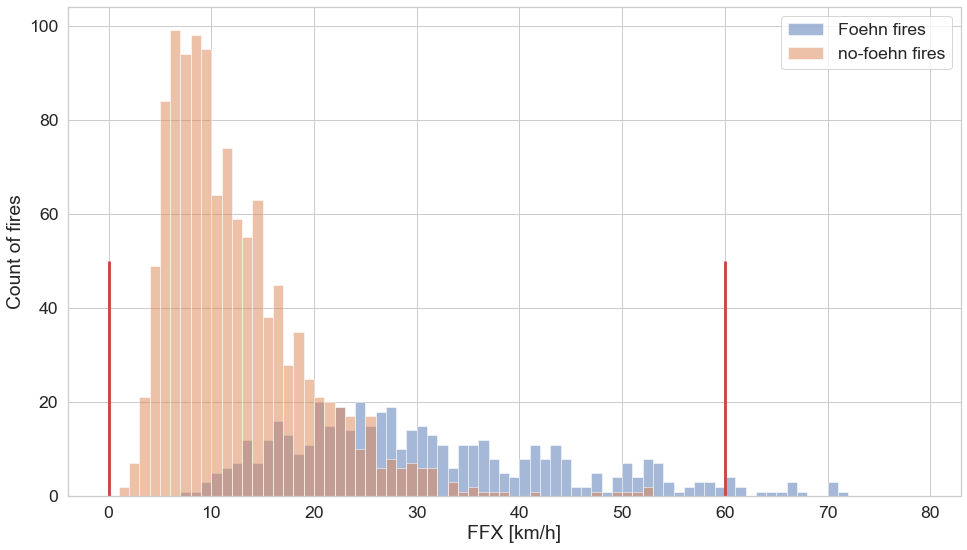

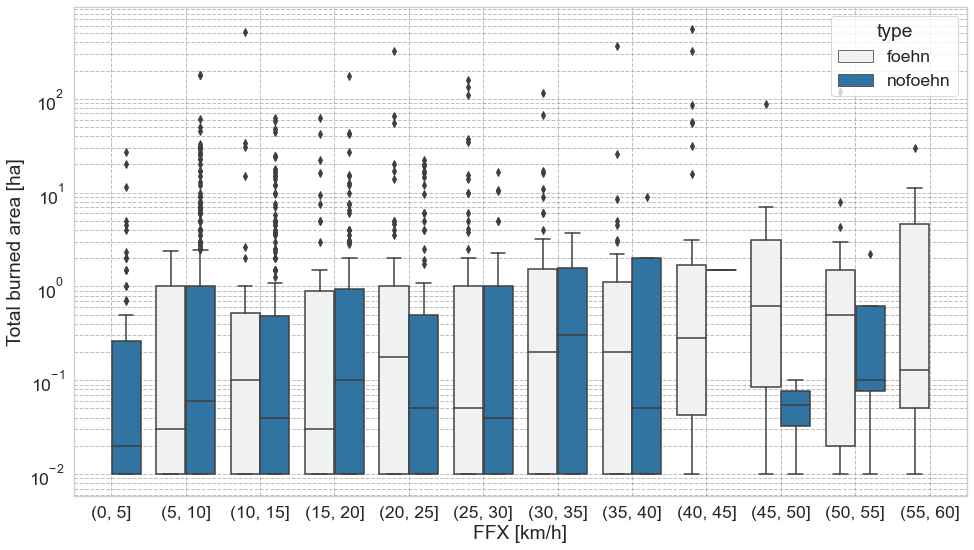

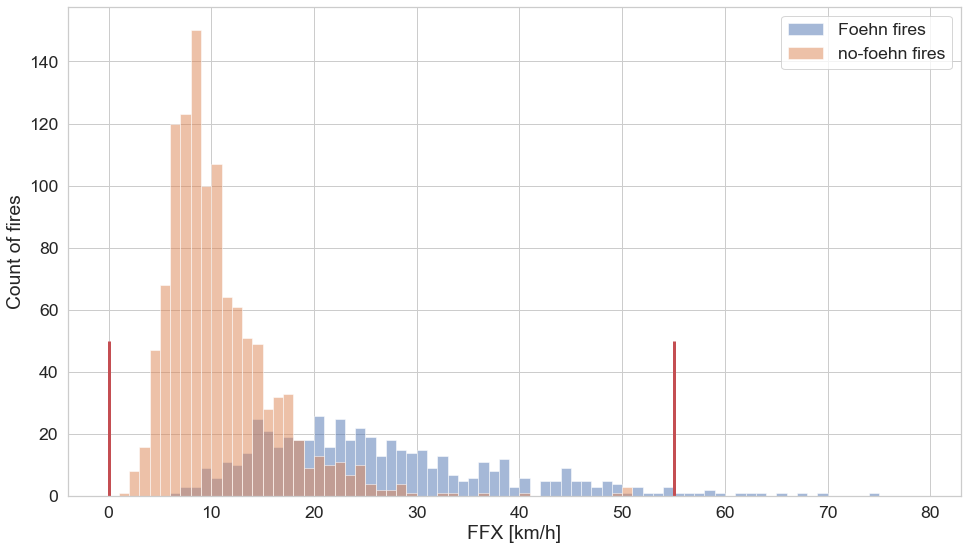

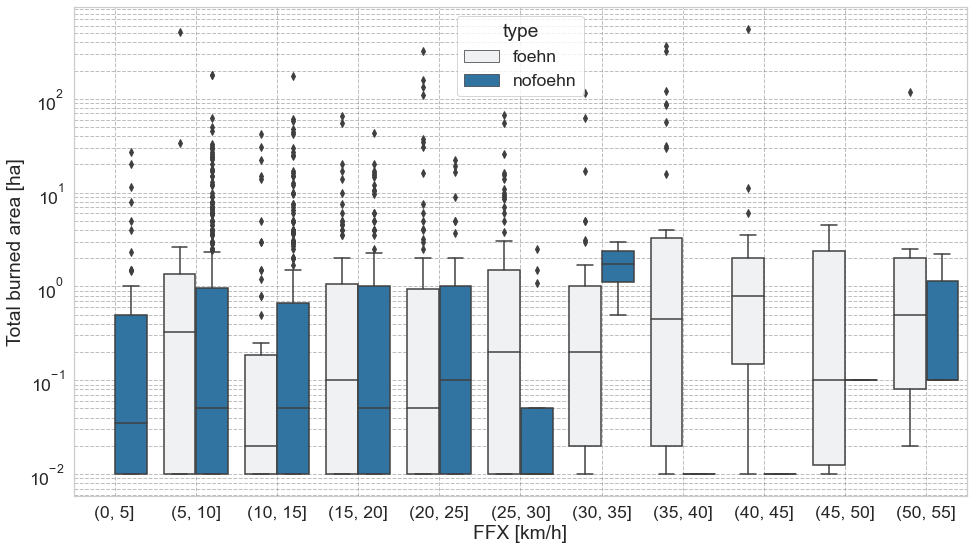

In [45]:
# OLD: bins_dict = {6: [5,6,11,60], 12: [0,6,10,60]}
bins_dict = {6: range(0,60+1,5), 12: range(0,55+1,5)}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength_foehn_nofoehn(df.loc[df["region"] == region, :].copy(), hours=hour, strength_var="FFX", bins=bins_dict[hour])
    break

# Before fire ignition

In [8]:
df_foehn = context.catalog.load("foehn_data_prepared")

2021-06-03 20:09:45,542 - kedro.io.data_catalog - INFO - Loading data from `foehn_data_prepared` (CSVDataSet)...


In [24]:
df_rain = context.catalog.load("rain_data")

# Since rain data goes from 0700 to 0700 the next day (Swiss time). Move to file at some point.
df_rain["date"] = df_rain["date"] + pd.Timedelta(hours=8) + pd.Timedelta(days=1)

2021-06-03 20:33:47,088 - kedro.io.data_catalog - INFO - Loading data from `rain_data` (CSVDataSet)...


In [25]:
df_merge = pd.merge(df_foehn, df_rain, on ="date", how="left")
#df_merge["date"] = df_merge["date"] + pd.Timedelta(hours=-100)

north
[67172.  7271.  4977.  4284.  2480.  1096.   732.]
foehn_minutes_24_hour_before
(-1, 1]         6106.545455
(1, 240]         661.000000
(240, 480]       452.454545
(480, 720]       389.454545
(720, 960]       225.454545
(960, 1200]       99.636364
(1200, 1440]      66.545455
Name: foehn_minutes_in_interval, dtype: float64
foehn_minutes_24_hour_before
(-1, 1]         987
(1, 240]        206
(240, 480]      209
(480, 720]      147
(720, 960]       84
(960, 1200]      52
(1200, 1440]     57
Name: total [ha], dtype: int64
[67172. 20840.]
foehn_minutes_24_hour_before
(-0.001, 0.001]    6106.545455
(0.001, 1440.0]    1894.545455
Name: foehn_minutes_in_interval, dtype: float64
foehn_minutes_24_hour_before
(-0.001, 0.001]    987
(0.001, 1440.0]    755
Name: total [ha], dtype: int64


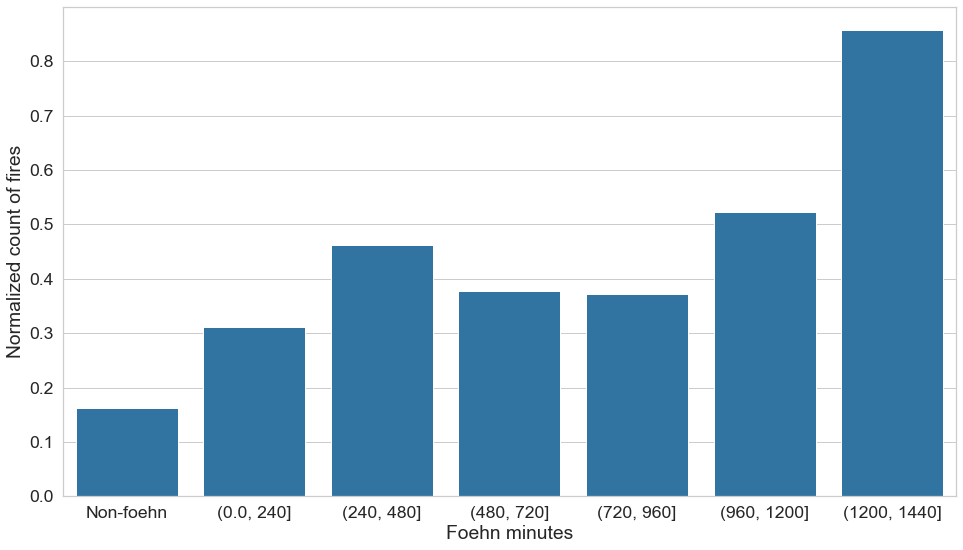

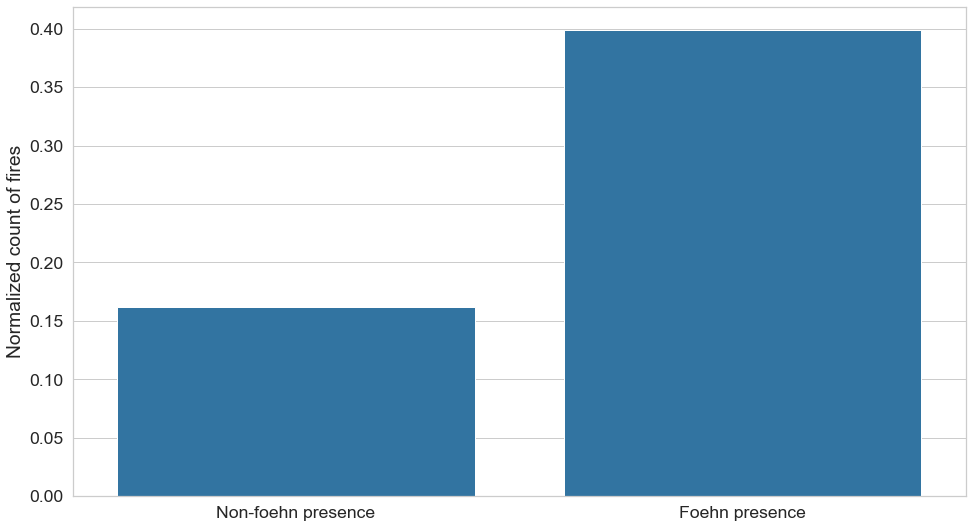

In [27]:
# Before fire start
for region in regions.keys():
    print(region)
    plot_binned_fire_count_before_fire_start(df.loc[df["region"] == region, :], df_foehn=df_merge, hours=24, stations_in_region=regions[region])
    break

## Temperature influence

In [ ]:
stations = [colname[0:3] for colname in df_foehn.filter(regex="foehn").columns]
north_foehn_stations = ["LUG", "OTL", "MAG", "COM", "GRO", "SBO", "PIO", "CEV", "ROB", "VIO"]
south_foehn_stations = set(stations) - set(north_foehn_stations)

for hour in [24,48]:
    plot_binned_fire_count_before_fire_start_temperature(df, df_foehn, hours=hour, stations=north_foehn_stations)

# Experimental

In [ ]:
df_foehn_copy=df_foehn.filter(regex="(foehn|TT)").copy() 
foehn_cols = df_foehn_copy.filter(regex="foehn").columns
temp_cols = df_foehn_copy.filter(regex="TT").columns

In [ ]:
df_foehn_copy.index = df_foehn["date"]

In [ ]:
df_foehn_copy = df_foehn_copy.between_time("18:00", "6:00", include_start=False, include_end=True)
df_foehn_copy.index = df_foehn_copy.index + pd.Timedelta("6h")

In [ ]:
group = df_foehn_copy.groupby(by=df_foehn_copy.index.date)
df_temp = group[temp_cols].first()- group[temp_cols].min()
df_f = group[foehn_cols].sum()*10
df_final = pd.concat([df_temp, df_f], axis=1)
df_final

In [ ]:
sns.histplot(df_final.loc[df_final["ALT_foehn"] >= 10, "ALT_TT"], stat="density", bins=range(0,15), color="r")
sns.histplot(df_final.loc[df_final["ALT_foehn"] == 0, "ALT_TT"],stat="density", bins=range(0,15))

In [ ]:
for i in df.index:
    station = df.loc[i, "closest_station"]
    start_date = pd.to_datetime(df.loc[i, "start date (solar time)"]).date()
    if start_date.year >1981:
        df.loc[i, "temp_decrease_during_night"] = df_final.loc[start_date, f"{station}_TT"]
        df.loc[i, "foehn_minutes_during_night"] = df_final.loc[start_date, f"{station}_foehn"]
    

In [ ]:
sns.histplot(df.loc[df["foehn_minutes_during_night"]>300, "temp_decrease_during_night"],bins=range(0,15),  color="r")
sns.histplot(df.loc[df["foehn_minutes_during_night"]==0, "temp_decrease_during_night"],bins=range(0,15))

In [ ]:
df_local = df.loc[df["foehn_minutes_during_night"]>0, :]

intervals = pd.cut(df_local["temp_decrease_during_night"], bins=6).value_counts().index
print(intervals.categories)

count_of_intervals = np.zeros(len(intervals))
print(count_of_intervals)
for col in temp_cols:
    station = col[0:3]
    if station == "GUE":
        continue
    df_loop = df_final.loc[df_final[f"{station}_foehn"]>0, :]
    #print(pd.cut(df_loop[col], bins=intervals.categories).value_counts())
    count_of_intervals = pd.cut(df_loop[col], bins=intervals.categories).value_counts()
    df_count = pd.cut(df_local.loc[df_local["closest_station"] == station, "temp_decrease_during_night"], bins=intervals.categories).value_counts(sort=False)
    plt.figure()
    sns.barplot(x=df_count.index, y=df_count/count_of_intervals)
    
# print(count_of_intervals/40)

# df_count = pd.cut(df_local["temp_decrease_during_night"], bins=6).value_counts(sort=False)
# print(df_count)
# print(df_count/count_of_intervals)
# sns.barplot(df_count.index, df_count/count_of_intervals*40)

In [ ]:
count_of_intervals

# Impact of foehn duration before fire on burned area

In [ ]:
# Plot all (or selected) plots for 6 and 12 hours after fire start
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [24,48]:
        plot_multiple_binned_burned_area_after_fire_start(df, hours=hours, variable="before", control_var=var)  

In [ ]:
# Plot all (or selected) plots for 6 and 12 hours after fire start
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [24,48]:
        plot_binary_binned_burned_area_after_fire_start(df, hours=hours, variable="before", control_var=var)  

In [ ]:
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [24,48]:
        test_binary_bins(df, hours=hours, variable="before", control_var=var, categories = control_var_categories[var])

In [ ]:
plot_binned_burned_area_before_and_after_fire_start(df, hours_before=24, hours_after=6)